# Lesson 28: TensorFlow/Keras neural network demonstration - part 2

## Notebook set up

### Imports

In [1]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

### GPU configuration

In [2]:
# Configure GPU settings
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Use only GPU 0
        tf.config.set_visible_devices(gpus[0], 'GPU')

        # Enable memory growth
        tf.config.experimental.set_memory_growth(gpus[0], True)

        print(f'Using GPU: {gpus[0]}')
        print('Memory growth enabled')

    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth enabled


## 1. Load California housing data

Load the preprocessed data from part 1 of the demo:

In [3]:
data = pd.read_pickle('https://gperdrizet.github.io/FSA_devops/assets/data/unit4/preprocessed_housing_data.pkl')
print(f'Data dictionary contains: {list(data.keys())}')

Data dictionary contains: ['training_df', 'testing_df', 'features', 'label', 'feature_scaler', 'label_scaler']


In [4]:
training_df = data['training_df']
testing_df = data['testing_df']
features = data['features']
label = data['label']

## 2. Build model

In [5]:
tf.random.set_seed(315)

model = keras.Sequential([
    layers.Input(shape=(8,)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

## 3. Callbacks

1. [Custom callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)
2. [Early stopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
3. [Model checkpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)
4. [Tensorboard](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)

To start tensorboard, run:

```text
tensorboard --logdir=path/to/log_dir/from/notebook_dir
```

Then visit the URL provided in your browser or via the 'ports' tab in VS Code. **Note**: if you are using the course tensorflow-GPU devcontainer environment, you do not need to start TensorBoard manually - it will start when you spin up the container. You can access it at `localhost:6006` or via the command pallette under `Python: Launch TensorBoard`.

In [ ]:
es_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

tensorboard = TensorBoard(
    log_dir='../logs',
    histogram_freq=1,
    write_graph=True
)

## 4. Train model

In [8]:
history = model.fit(
    training_df[features],
    training_df[label],
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[checkpoint, tensorboard],
    verbose=0
)

print('Training complete.')
print(f'Final training loss: {history.history["loss"][-1]:.4f}')
print(f'Final validation loss: {history.history["val_loss"][-1]:.4f}')

I0000 00:00:1769138210.941555  356963 service.cc:145] XLA service 0x71278808b040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769138210.941592  356963 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769138211.060522  356963 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training complete.
Final training loss: 0.2425
Final validation loss: 0.2457


## 5. Learning curves

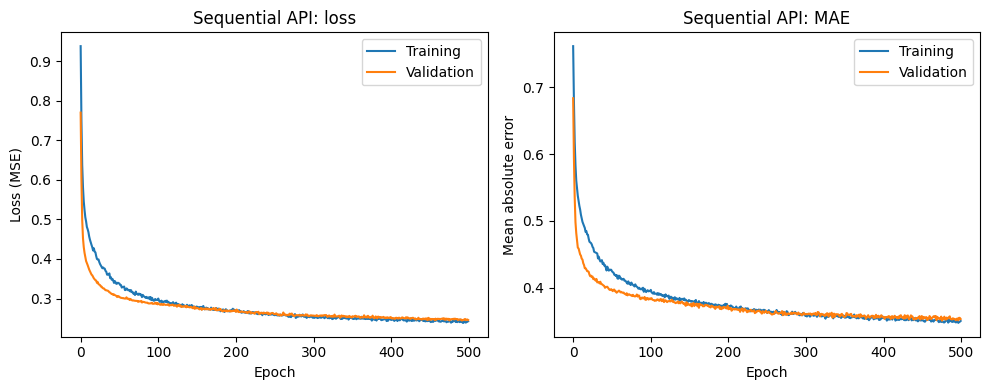

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Sequential API: loss')
axes[0].plot(history.history['loss'], label='Training')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend(loc='best')

axes[1].set_title('Sequential API: MAE')
axes[1].plot(history.history['mae'], label='Training')
axes[1].plot(history.history['val_mae'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean absolute error')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

## 6. Test set evaluation

In [10]:
predictions = model.predict(testing_df[features], verbose=0).flatten()

ss_res = np.sum((testing_df[label] - predictions) ** 2)
ss_tot = np.sum((testing_df[label] - np.mean(testing_df[label])) ** 2)
rsquared = 1 - (ss_res / ss_tot)

print(f'Model R² on test set: {rsquared:.4f}')

Model R² on test set: 0.7674


## 7. Performance analysis

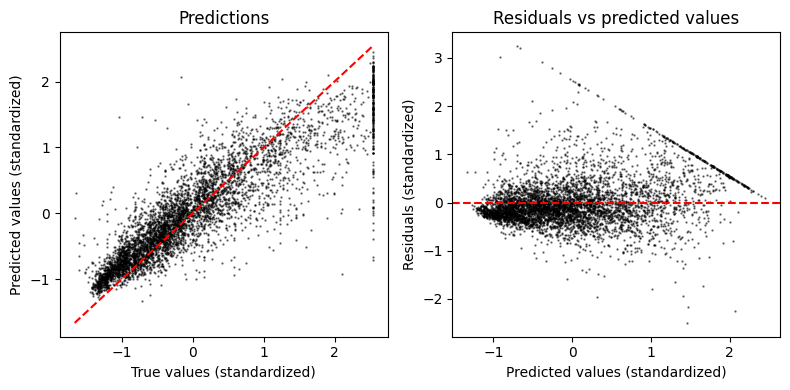

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('Predictions')
axes[0].scatter(
    testing_df[label], predictions,
    c='black', s=0.5, alpha=0.5
)

axes[0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)

axes[0].set_xlabel('True values (standardized)')
axes[0].set_ylabel('Predicted values (standardized)')

axes[1].set_title('Residuals vs predicted values')
axes[1].scatter(
    predictions, testing_df[label] - predictions,
    c='black', s=0.5, alpha=0.5
)

axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted values (standardized)')
axes[1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()

## 8. Save the model

In [12]:
model.save('housing_price_model_sequential_api.keras')

## 9. Load the model

In [13]:
loaded_model = keras.models.load_model('housing_price_model_sequential_api.keras')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3